In [1]:
import numpy as np
import json
from os.path import join
from tifffile import imsave, imread
from scipy.io import loadmat
import matplotlib.pyplot as plt
import GradientDescent
from utils import save_array_as_image
import scipy.sparse as sp
from scipy.fft import fftshift, ifftshift, fft,fft2,ifft2
from scipy.ndimage import gaussian_filter
from scipy import signal

## (i) Image Denoising

error gaussian noise:  31290.1869176628
error poisson noise:  256102.13178925318
error salt&pepper noise:  43282.09062649354
3
238


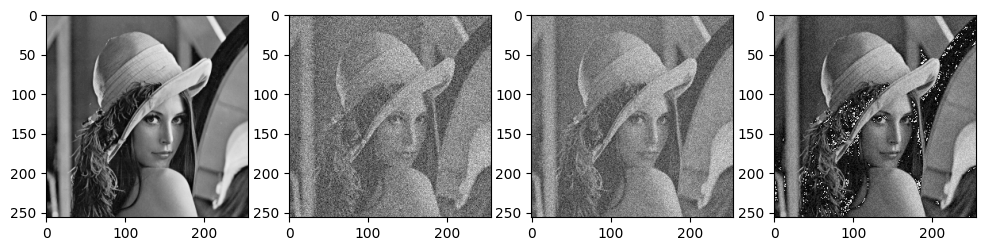

In [106]:
file_name = 'lena.tif'
image = imread(file_name)

# Gaussian noise
gaussian_noise = np.random.normal(0, 50, image.shape)
noisy_image_gaussian = image + gaussian_noise
print('error gaussian noise: ',np.linalg.norm(gaussian_noise-image))

# Poisson noise
poisson_noise = np.random.poisson(1000, image.shape)
noisy_image_poisson  = image + poisson_noise
print('error poisson noise: ',np.linalg.norm(noisy_image_poisson-image))

# Salt and pepper noise
random_mask = np.random.choice([min_value, max_value], size=image.shape)
salt_pepper_noise = np.where(random_mask == min_value, min_value, max_value)
noisy_image_salt_pepper = image + salt_pepper_noise
print('error salt&pepper noise: ',np.linalg.norm(noisy_image_salt_pepper-image))
min_value = np.min(image)
print(min_value)
max_value = np.max(image)
print(max_value)
plt.figure(figsize=(12,12))
plt.subplot(1,4,1);plt.imshow(image,cmap='gray')
plt.subplot(1,4,2);plt.imshow(noisy_image_gaussian,cmap='gray')
plt.subplot(1,4,3);plt.imshow(noisy_image_poisson,cmap='gray')
plt.subplot(1,4,4);plt.imshow(noisy_image_salt_pepper,cmap='gray')
plt.show()

Setup the problem as least square formulation 0.5|Ax-b|^2 and solve using techniques from Homework 1

In [4]:
A = sp.eye(image.size) #np.eye(image.size) 
b_gaussian = noisy_image_gaussian.flatten()
b_poisson = noisy_image_poisson.flatten()
b_salt_pepper = noisy_image_salt_pepper.flatten()

Denoising experiments

final x:  [50.04253776 76.23375671 44.3646982  ... 51.81839787 51.65985009
 35.37159501]
iteration gd: 670
error gd(tikhonov):  19557.593880908615
final x:  [49.9192173  76.15627828 44.23143992 ... 51.69818567 51.53936038
 35.22259626]
iteration OGM: 2500
error OGM(tikhonov):  19589.540691015398
final x:  [49.77271451 76.0642351  44.07313114 ... 51.55537543 51.39622048
 35.04558805]
iteration FGM: 2500
error FGM(tikhonov):  19627.535269521402
final x:  [148.14175307 226.75562479 131.09951643 ... 153.4720601  152.99617332
 104.10639856]
iteration ogm: 2500
error ogm(huber):  12744.781824466094
chosen w:  0.01
iteration lwb: 500
error:  12759.064633303733
chosen w(sirt):  0.01
iteration sirt: 500
error:  12759.064633303733
iteration cg: 1
error:  12842.60232494789


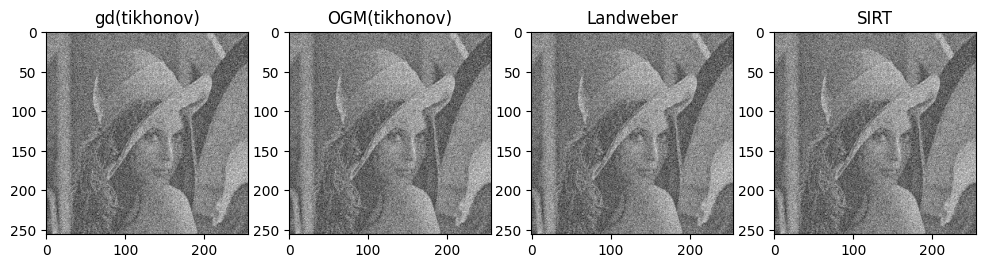

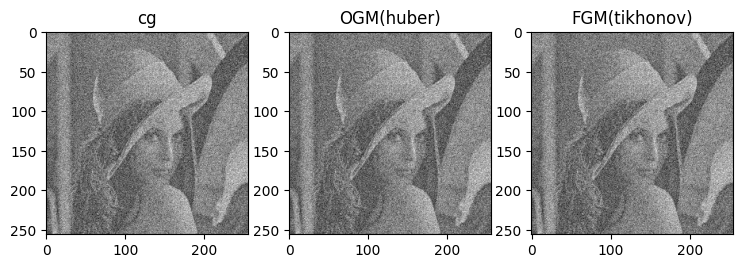

In [64]:
size = A.shape[1]
median = (min_value + max_value) /2
x0 =np.ones(size)*median #  np.random.uniform(50, 52, size) 

lena_gd, iteration_GD = GradientDescent.compute_GD(A,b_gaussian,0.01,x0,beta=2,regularizer='tikhonov',iteration=4000)
lena_gd= lena_gd.reshape((256,256))
print('iteration gd:',iteration_GD)
print('error gd(tikhonov): ',np.linalg.norm(lena_gd-image))

ogm_tik, iteration_OGM = GradientDescent.compute_OGM1(A,b_gaussian,10000,x0,beta=2,delta=2,regularizer='tikhonov',iteration=2500)
ogm_tik= ogm_tik.reshape((256,256))
print('iteration OGM:',iteration_OGM)
print('error OGM(tikhonov): ',np.linalg.norm(ogm_tik-image))

fgm_tik, iteration_FGM = GradientDescent.compute_FGM1(A,b_gaussian,10000,x0,beta=2,delta=2,regularizer='tikhonov',iteration=2500)
fgm_tik= fgm_tik.reshape((256,256))
print('iteration FGM:',iteration_OGM)
print('error FGM(tikhonov): ',np.linalg.norm(fgm_tik-image))

ogm_huber, iteration_GD = GradientDescent.compute_OGM1(A,b_gaussian,10000,x0,beta=2,regularizer='huber',iteration=2500)
ogm_huber= ogm_huber.reshape((256,256))
print('iteration ogm:',iteration_GD)
print('error ogm(huber): ',np.linalg.norm(ogm_huber-image))

lena_lwb, iteration_lwb = GradientDescent.compute_Landweber(A,b_gaussian,0.01,x0,iteration=500)
lena_lwb= lena_lwb.reshape((256,256))
print('iteration lwb:',iteration_lwb)
print('error: ',np.linalg.norm(lena_lwb-image))

lena_sirt, iteration_sirt = GradientDescent.compute_SIRT(A,b_gaussian,0.01,x0,iteration=500)
lena_sirt= lena_sirt.reshape((256,256))
print('iteration sirt:',iteration_sirt)
print('error: ',np.linalg.norm(lena_sirt-image))

x0 =np.zeros(size)+(-1e-10)
lena_cg, iteration_cg = GradientDescent.conjugate_gradient_normal(A,b_gaussian,x0,iteration=1)
lena_cg= lena_cg.reshape((256,256))
print('iteration cg:',iteration_cg)
print('error: ',np.linalg.norm(lena_cg-image))

plt.figure(figsize=(12,12))
plt.subplot(1,4,1, title="gd(tikhonov)");plt.imshow(lena_gd,cmap='gray')
plt.subplot(1,4,2, title="OGM(tikhonov)");plt.imshow(ogm_tik,cmap='gray')
plt.subplot(1,4,3, title="Landweber");plt.imshow(lena_lwb,cmap='gray')
plt.subplot(1,4,4, title="SIRT");plt.imshow(lena_sirt,cmap='gray')

plt.figure(figsize=(12,12))
plt.subplot(2,4,1, title="cg");plt.imshow(lena_cg,cmap='gray')
plt.subplot(2,4,2, title="OGM(huber)");plt.imshow(ogm_huber,cmap='gray')
plt.subplot(2,4,3, title="FGM(tikhonov)");plt.imshow(fgm_tik,cmap='gray')
#plt.subplot(2,4,4, title="8");plt.imshow(lena_gd,cmap='gray')
plt.show()


## (ii) Image Deblurring

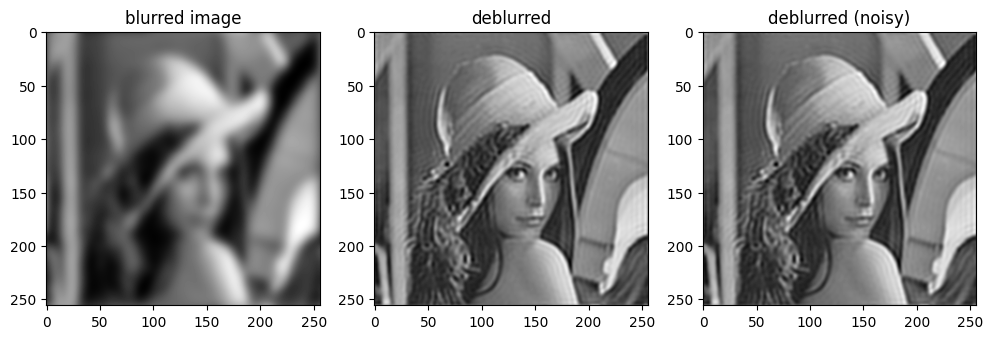

In [97]:
sigma = 5
## convolution
def convolve2(image, sigma):
    H = np.linspace(-1,1,image.shape[0])
    
    H = np.exp(-H**2/(2*sigma**2))
    
    return img_convolved, freq_kernel

# lena_64 = bin_array(image,4)
image_convolved, kernel = convolve(image, sigma)

## deconvolution
def deconvolve2(image, kernel):
    image_fft = fft2(image_convolved)
    epsilon = 1e-6
    deconvolved = np.nan_to_num(np.divide(image_fft,kernel+epsilon))
    img_deconvolved = ifft2(deconvolved).real
    
    return img_deconvolved

## convolution
def convolve(image, sigma):
    image_fft = fft2(image)
    gauss_kernel = np.outer(signal.gaussian(image.shape[0], sigma), signal.gaussian(image.shape[1], sigma))
    freq_kernel = fft2(ifftshift(gauss_kernel))
    convolved = image_fft*freq_kernel
    img_convolved = ifft2(convolved).real
    
    return img_convolved, freq_kernel

# lena_64 = bin_array(image,4)
image_convolved, kernel = convolve(image, sigma)

## deconvolution
def deconvolve(image, kernel):
    image_fft = fft2(image_convolved)
    epsilon = 1e-6
    deconvolved = np.nan_to_num(np.divide(image_fft,kernel+epsilon))
    img_deconvolved = ifft2(deconvolved).real
    
    return img_deconvolved

# poisson_noise2 = np.random.poisson(1000, lena_64.shape)
noisy_blurred_img = image_convolved + poisson_noise
img_deconvolved = deconvolve(image_convolved, kernel)
noisy_img_deconvolved = deconvolve(noisy_blurred_img, kernel)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1, title="blurred image");plt.imshow(image_convolved,cmap='gray')
plt.subplot(1,3,2, title="deblurred");plt.imshow(img_deconvolved,cmap='gray')
plt.subplot(1,3,3, title="deblurred (noisy)");plt.imshow(noisy_img_deconvolved,cmap='gray')
plt.show()

(i) ordinary gradient descent

10


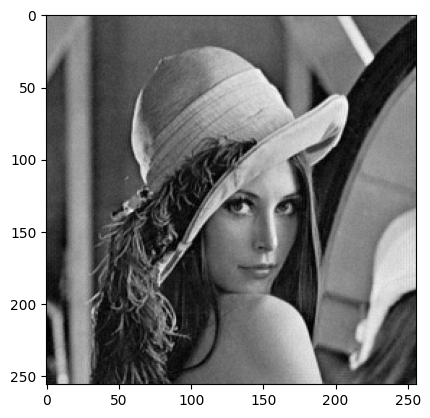

In [98]:
x2 = np.random.rand(256,256)*10
b2 = image_convolved.flatten()
alpha = 0.01
eps = 1e-3

for i in range(10):
    conv, kernel = convolve(x2, sigma)
    grad = deconvolve(conv - image_convolved, kernel)
    new_x = x2 - alpha*grad
    stopIdx=i
    if np.linalg.norm(new_x-x) < eps:
        break
    x2 = new_x

print(stopIdx+1)
plt.imshow(np.abs(x),cmap='gray')
 

(ii) OGM

10


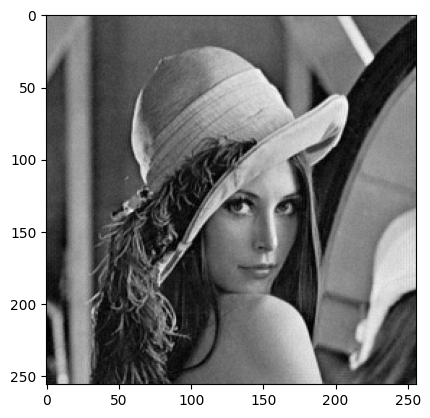

In [104]:
x2 = np.random.rand(256,256)*1
y = x2.copy()
theta = 1
stopIdx = 0
L = 1000
iteration = 10

for i in range(iteration):
    conv, kernel = convolve(x2, sigma)
    grad = deconvolve(conv - image_convolved, kernel)
    new_y = x2 - (1/L)*grad
    other_term = (1+np.sqrt(1+4*np.square(theta))) / 2
    last_term = (1+np.sqrt(1+8*np.square(theta))) / 2
    new_theta = np.where(i==iteration-1, last_term, other_term)
    new_x = new_y + ((theta-1)/new_theta)*(new_y-y)+(theta/new_theta)*(new_y-x2)
    stopIdx=i
    if np.linalg.norm(new_x - x2) < eps:
        
        break
    y = new_y
    theta = new_theta
    x2 = new_x
    
print(stopIdx+1)
plt.imshow(np.abs(x),cmap='gray')

In [3]:
signal.gaussian(3, 0.5)

array([0.13533528, 1.        , 0.13533528])

In [5]:
sigma = 0.5
size = 3
kernel = np.fromfunction(lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - size//2)**2 + (y - size//2)**2) / (2 * sigma**2)), (size, size))
print(kernel / np.sum(kernel))

[[0.01134374 0.08381951 0.01134374]
 [0.08381951 0.61934703 0.08381951]
 [0.01134374 0.08381951 0.01134374]]
